In [1]:
%cd ~/dev/event-camera/src

/home/gianscarpe/dev/event-camera/src


In [44]:
from experimenting.dataset.factory import Joints3DConstructor
from experimenting.dataset import get_dataloader

from matplotlib import pyplot as plt
import numpy as np
from albumentations import Compose, CenterCrop
from albumentations.pytorch import ToTensor
import torch
from importlib import reload  
from experimenting.models import metrics, losses

from omegaconf import DictConfig

from experimenting.utils import get_file_paths
from experimenting.utils import visualization
from experimenting.utils import cv_helpers
import experimenting.utils.skeleton_helpers as skeleton_helpers
import numpy as np
import glob
import os

%matplotlib inline

In [3]:
homedir = '/data/gscarpellini/dhp19'
dataset = 'time_count_dataset'
exp_dataset = 'timecount'


data_dir = os.path.join(homedir, dataset, 'movements_per_frame')
labels_dir = os.path.join(homedir, dataset, "labels_full_joints/")

test_subjects = [1, 2, 3, 4, 5]
cams = [0,1,2,3]

batch_size = 32

hparams = DictConfig({'dataset':{'data_dir': data_dir, 'core_class': 'DHP19Core', 'save_split':False, 'hm_dir': labels_dir,'joints_dir' :
                      labels_dir, 'test_subjects':test_subjects, 'split_at':0.8, 'cams': cams,
                                'movements': [0]}, 
                       'augmentation_test': {'info':{'in_shape':[260, 346]}, 'apply':{'aug_1': {'cls': 'albumentations.pytorch.ToTensor'}}},
                      'augmentation_train': {'info':{'in_shape':[260, 346]}, 'apply':{'aug_1': {'cls': 'albumentations.pytorch.ToTensor'}}}
                     })

In [4]:
factory = Joints3DConstructor(hparams)
train, val, test = factory.get_datasets()
loader = get_dataloader(test, batch_size, shuffle=False, num_workers=2)

.npy|.mat


In [5]:
train, val, test = factory.get_datasets()
loader = get_dataloader(test, batch_size, shuffle=False, num_workers=2)

In [201]:
batch = next(iter(loader))
x, y = batch

In [268]:
def visualize_frame_and_skeleton(x, y,  i=0, points=None):
    M = y['M'][i]
    K = y['camera'][i]
    P = torch.matmul(K[:, :3], M)
    frame = x[i].squeeze().numpy()
    gt = skeleton_helpers.Skeleton(y['xyz'][i])
    
    pred = None
    if points is not None:
        pred = skeleton_helpers.Skeleton(points)
    visualization.plot_2d_from_3d(frame, gt, P, pred_skeleton=pred)

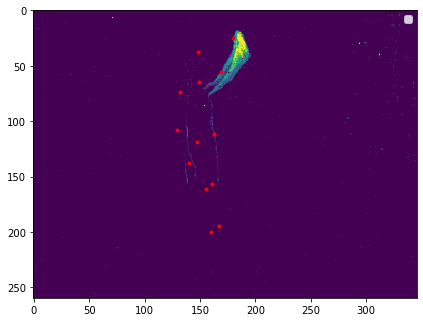

In [269]:
visualize_frame_and_skeleton(x, y, 30)

## Eval margipose model

In [172]:
ls /home/gianscarpe/dev/exps/timecount_dhp19/exps_MargiposeEstimator/

08-31-15-54_exp_ae_resnet34_cut_512_pretrained_True_08-31-15-54/
09-02-10-10_exp_resnet34_pretrained_True_09-02-10-10/
09-02-11-18_exp_resnet34_pretrained_True_09-02-11-18/
09-02-11-24_exp_resnet34_pretrained_True_09-02-11-24/
09-02-11-27_exp_resnet34_pretrained_True_09-02-11-27/
09-02-11-34_exp_resnet34_pretrained_True_09-02-11-34/
09-02-11-37_exp_resnet34_pretrained_True_09-02-11-37/
09-02-11-45_exp_resnet34_pretrained_True_09-02-11-45/
09-02-11-49_exp_resnet34_pretrained_True_09-02-11-49/
09-02-11-50_exp_resnet34_pretrained_True_09-02-11-50/
09-02-13-32_exp_resnet34_pretrained_True_09-02-13-32/
cross-subject/
cross-view/
exp_ae_resnet34_cut_256_$Adam_0.0003_no_aug_08-24-11-22/
#summary.csv#
summary.csv
with_errors/


In [168]:
exp_dir = f'/home/gianscarpe/dev/exps/timecount_dhp19/exps_MargiposeEstimator'

exps = sorted(glob.glob(os.path.join(exp_dir,'exp*')))
print(list(exps))

['/home/gianscarpe/dev/exps/timecount_dhp19/exps_MargiposeEstimator/exp_ae_resnet34_cut_256_$Adam_0.0003_no_aug_08-24-11-22']


In [179]:
import experimenting.agents as agents
import os
import experimenting.models.metrics as metrics
import experimenting.models.losses as losses
from experimenting.utils import get_joints_from_heatmap, average_loss, decompose_projection_matrix, get_checkpoint_path
import experimenting.utils.cv_helpers as utils
exp_name = "exp_ae_resnet34_cut_256_$Adam_0.0003_no_aug_08-24-11-22/"
checkpoint_dir = os.path.join(exp_dir, exp_name, 'checkpoints')
checkpoint_path = get_checkpoint_path(checkpoint_dir)

model = agents.MargiposeEstimator.load_from_checkpoint(checkpoint_path)
model = model.cpu()

/home/gianscarpe/anaconda3/envs/event-camera/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/gianscarpe/anaconda3/envs/event-camera/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torchvision.models.resnet.BasicBlock' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [180]:
checkpoint_path

'/home/gianscarpe/dev/exps/timecount_dhp19/exps_MargiposeEstimator/exp_ae_resnet34_cut_256_$Adam_0.0003_no_aug_08-24-11-22/checkpoints/epoch=26-val_loss=0.08.ckpt'

PRED XY


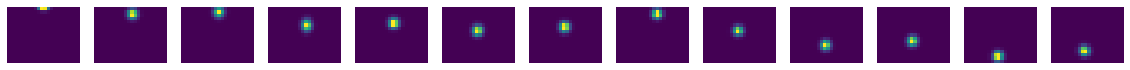

PRED ZY


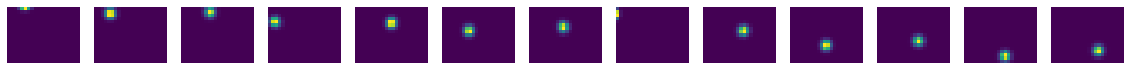

PRED XZ


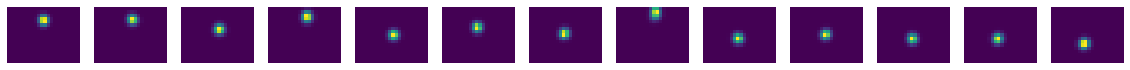

In [182]:
idx = 0

y_sample = np.load(test.dataset.joints[test.x_indexes[0]])
x_sample, _ = test[idx]

with torch.no_grad():
    preds = model(x_sample.unsqueeze(0))

#plt.imshow(x_sample.squeeze())

# XY
print("PRED XY")
visualization.plot_heatmap(preds[0][-1][0])

# ZY
print("PRED ZY")
visualization.plot_heatmap(preds[1][-1][0])

# XZ
print("PRED XZ")
visualization.plot_heatmap(preds[2][-1][0])


In [275]:
reload(visualization)

<module 'experimenting.utils.visualization' from '/home/gianscarpe/dev/event-camera/src/experimenting/utils/visualization.py'>

In [242]:
preds_xyz[i][:, 1] *= -1

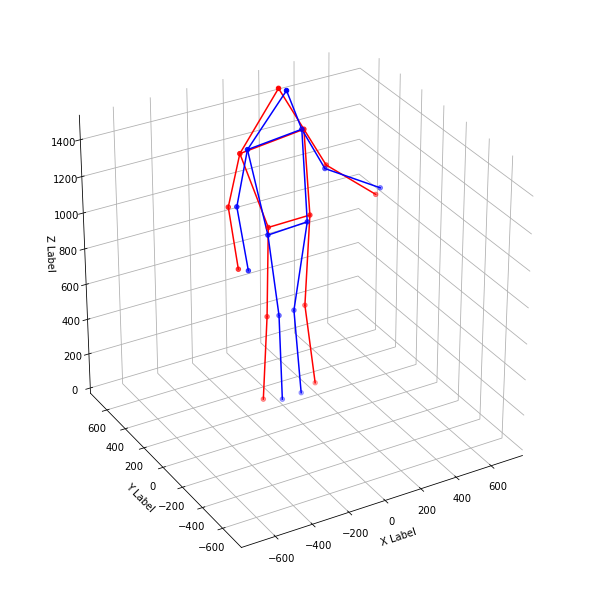

In [258]:
from mpl_toolkits.mplot3d import Axes3D



#plt.legend()
# Get rid of colored axes planes
# First remove fill
fig = plt.figure(figsize=(8, 8))
ax = Axes3D(fig)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# Bonus: To get rid of the grid as well:
ax.grid(True)
ax.view_init(30, 240)
pred_skeleton.plot_3d(ax, c='red')
gt_skeleton.plot_3d(ax, c='blue')

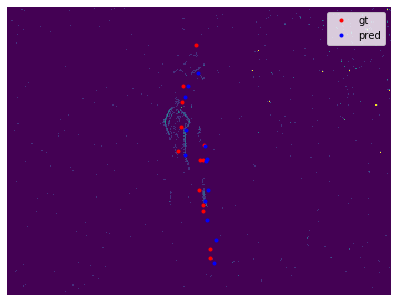

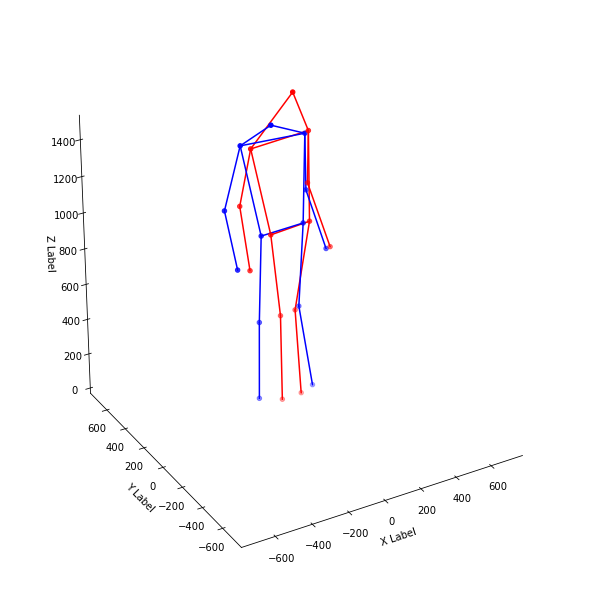

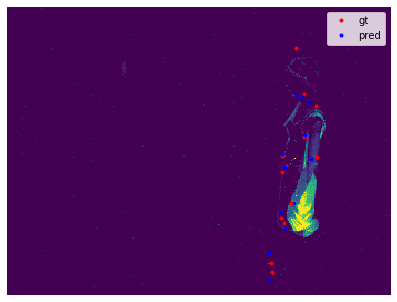

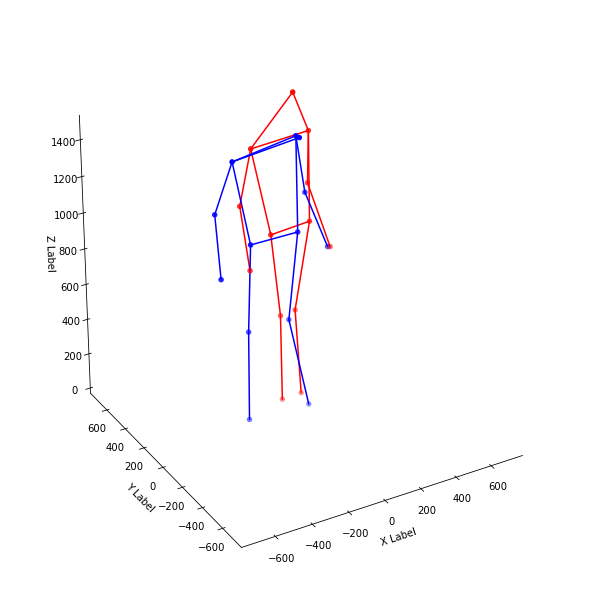

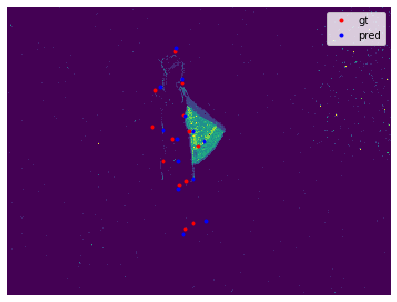

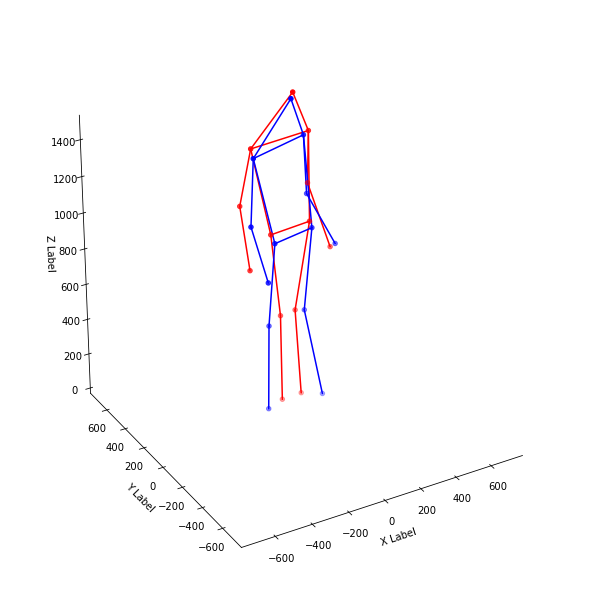

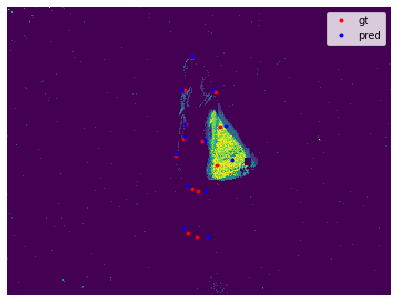

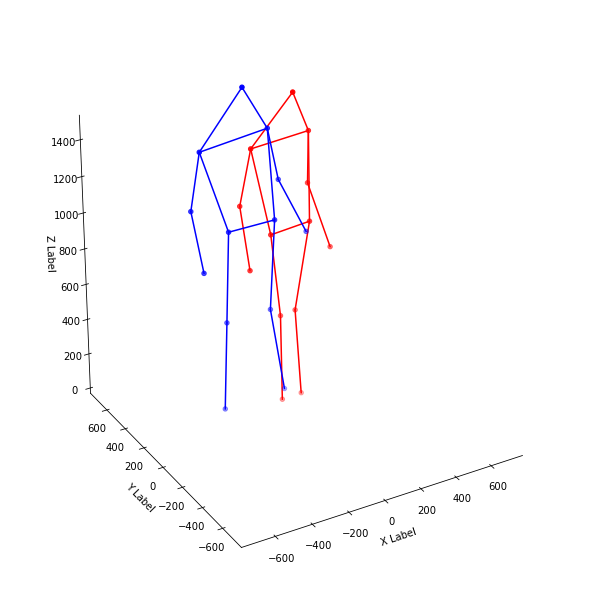

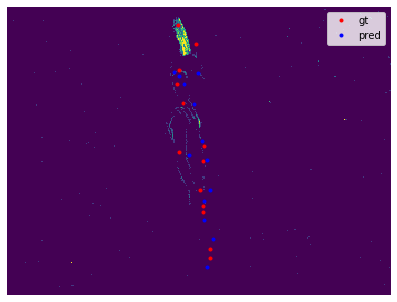

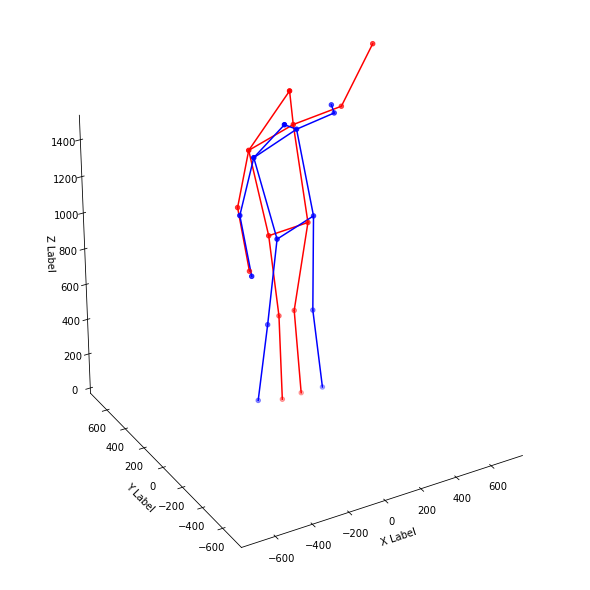

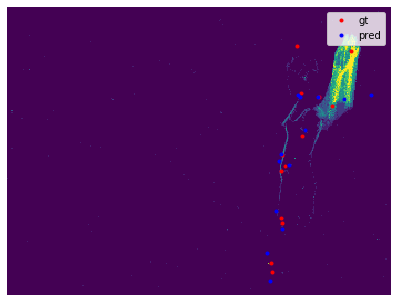

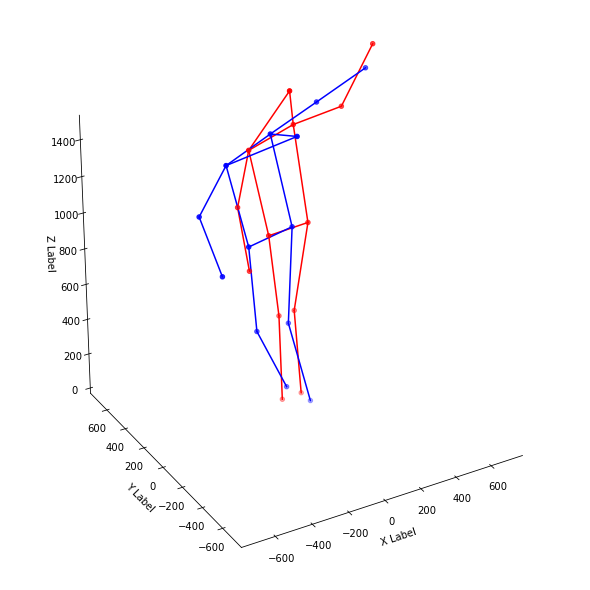

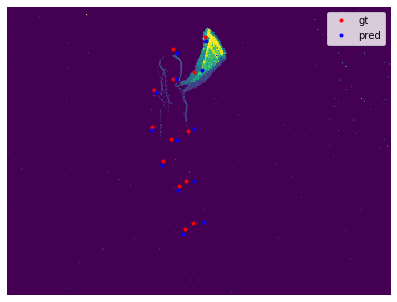

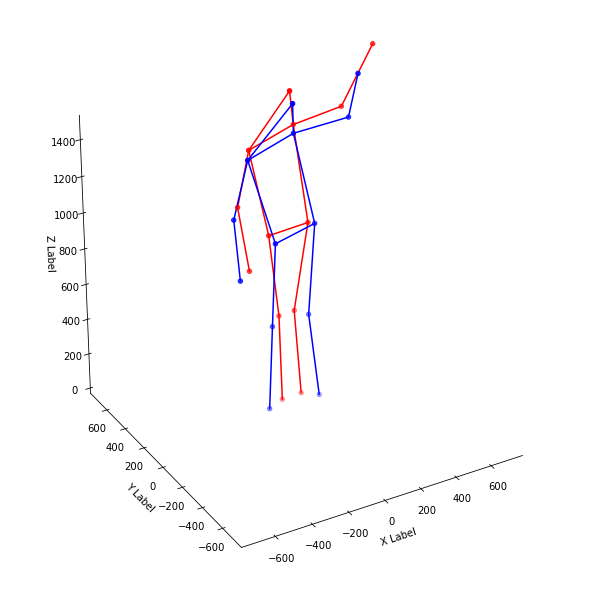

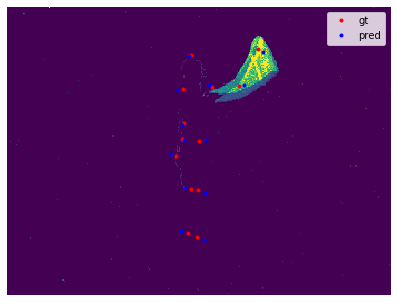

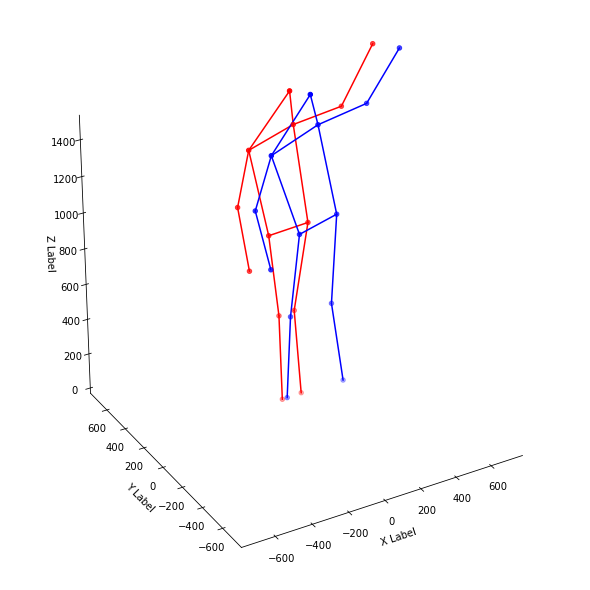

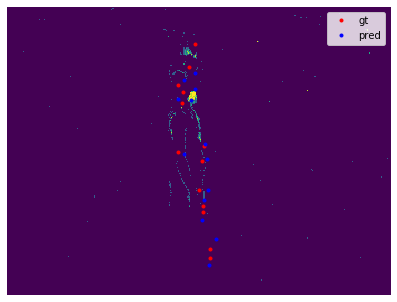

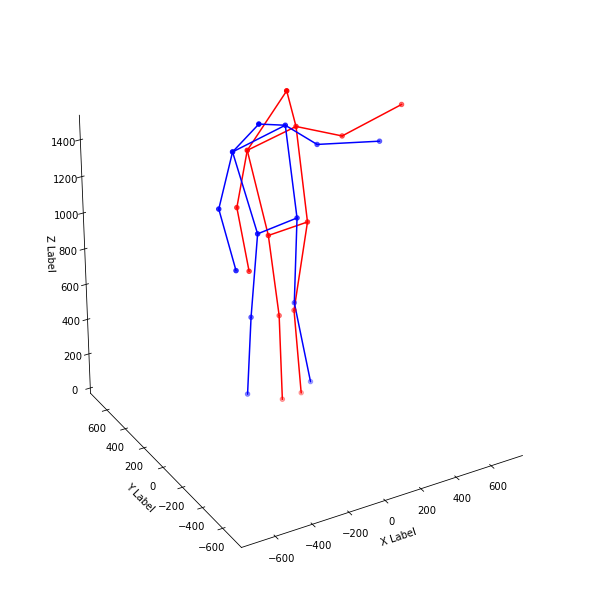

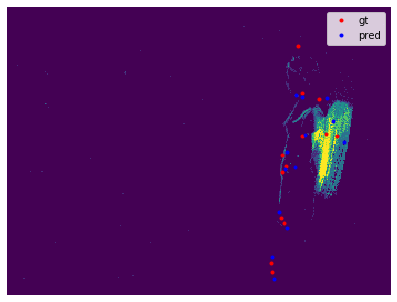

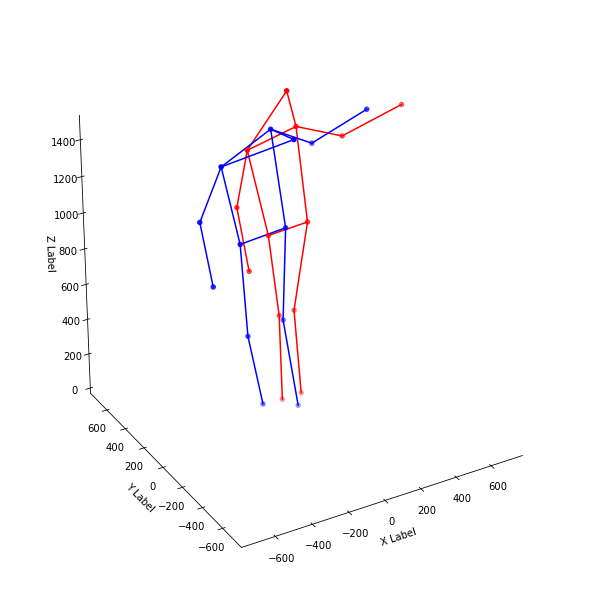

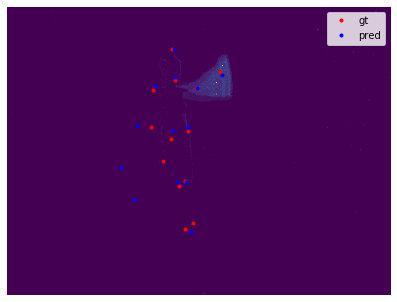

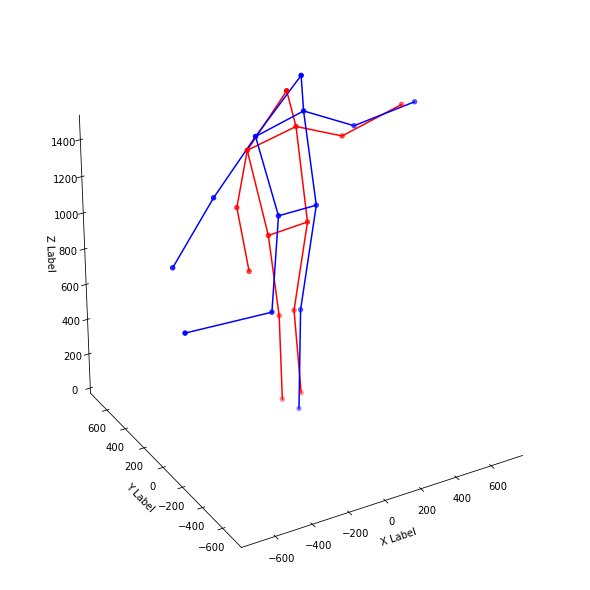

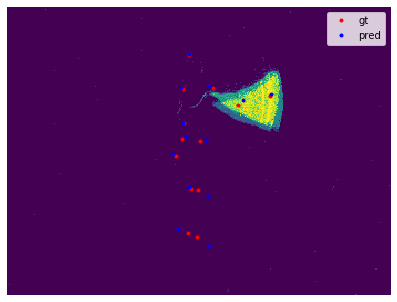

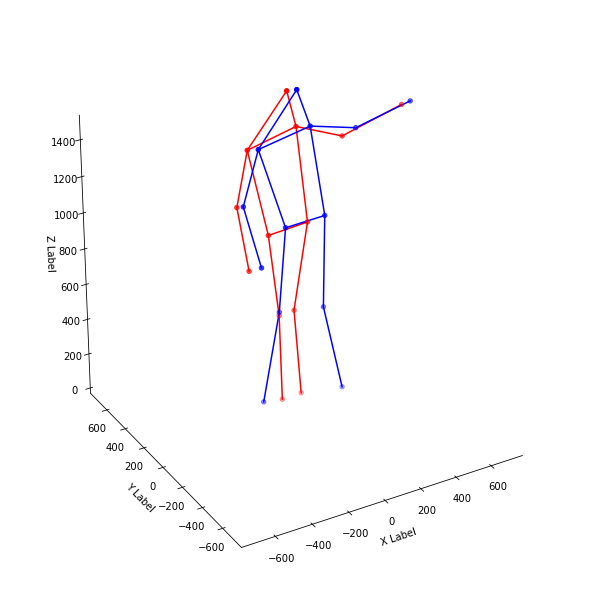

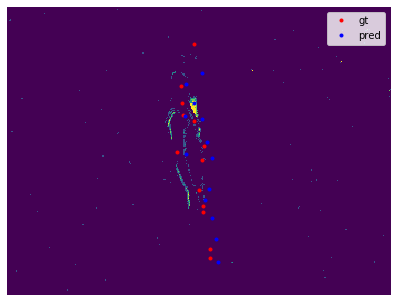

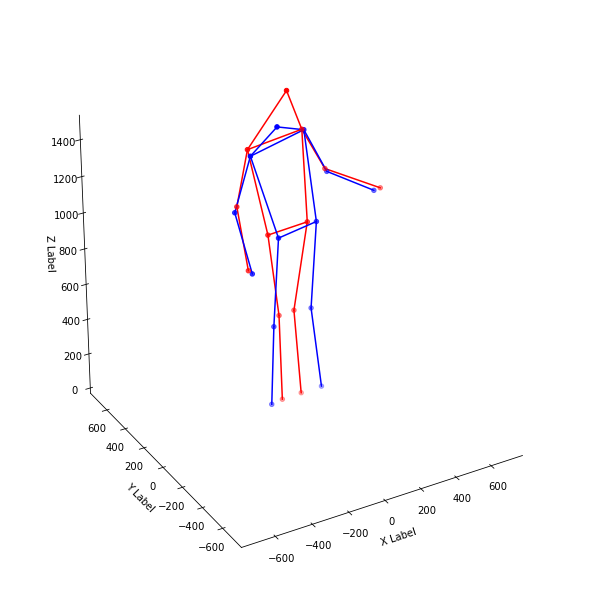

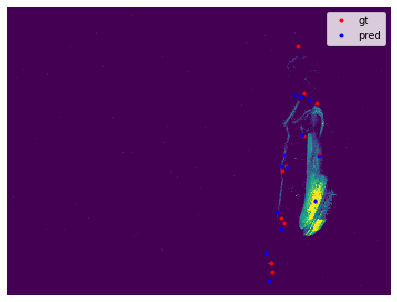

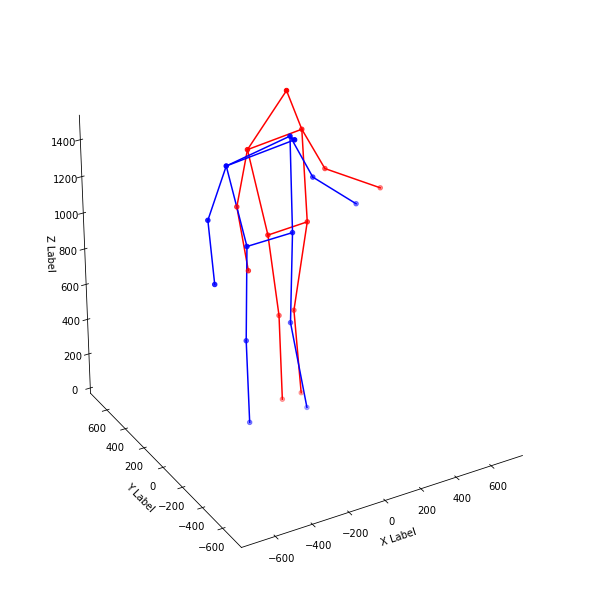

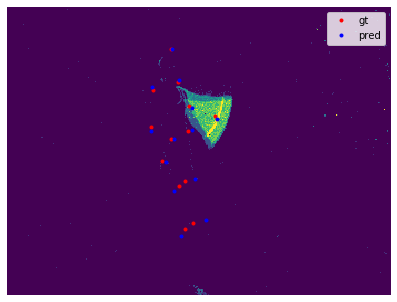

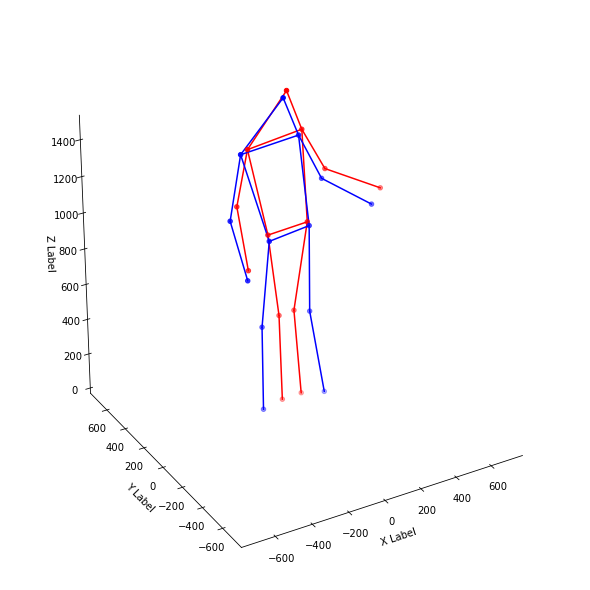

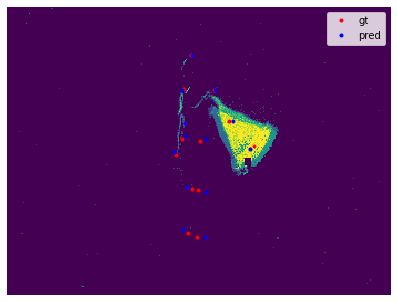

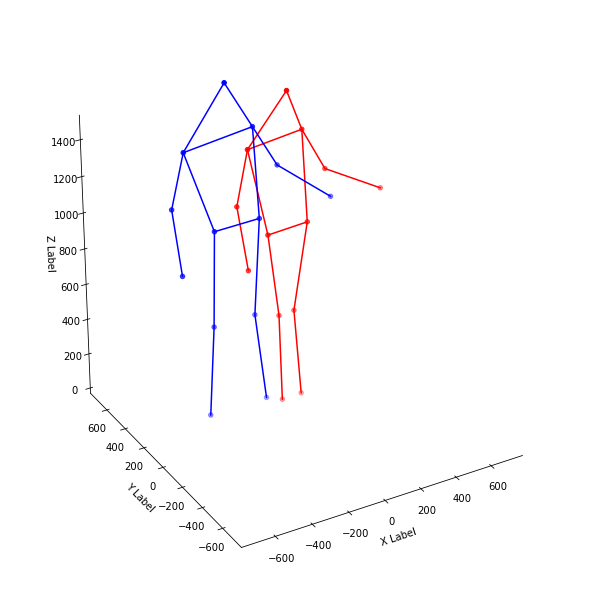

In [279]:
from experimenting.agents.margipose_estimator import predict3d
model.estimate_depth = True
reload(visualization)
reload(skeleton_helpers)
with torch.no_grad():
    preds = model(x.cpu())
    xy = preds[0][-1]
    zy = preds[1][-1]
    xz = preds[2][-1]
    normalized_skeletons = predict3d(xy, zy, xz)


gts_xyz = y['xyz'][:16]
preds_xyz = model.denormalize_predictions(normalized_skeletons, y)
for i in range(16):
    gt_skeleton = skeleton_helpers.Skeleton(y['xyz'][i])
    visualize_frame_and_skeleton(x, y, i, preds_xyz[i])
    pred_skeleton = skeleton_helpers.Skeleton(preds_xyz[i])
    visualization.plot_skeleton_3d(gt_skeleton, pred_skeleton)


# Test video 

In [214]:
import glob
import numpy as np
import h5py
import cv2

In [362]:
root_dir = os.path.join(homedir, dataset, "346x260/")

x_paths = sorted(glob.glob(os.path.join(root_dir, "S1_*events.*")))

In [360]:
# Load matrix

P_mat_dir = os.path.join(homedir, 'P_matrices/')
P_mat_cam3 = np.load(os.path.join(P_mat_dir,'P2.npy'))
M,_ = decompose_projection_matrix(P_mat_cam3)


In [ ]:
x_h5 = h5py.File(x_paths[0], 'r')

In [ ]:
frames = x_h5['DVS'][..., 2]

In [364]:
os.listdir(root_dir)

FileNotFoundError: [Errno 2] No such file or directory: '/data/gscarpellini/dhp19/voxel_grid_dataset/346x260/'

In [308]:
M, K = decompose_projection_matrix(P_mat_cam3)
K = torch.tensor(K)

In [310]:
K

tensor([[358.5965,   6.4216, 168.3375,   0.0000],
        [  0.0000, 359.4310, 126.4609,   0.0000],
        [  0.0000,   0.0000,   1.0000,   0.0000]], dtype=torch.float64)

In [244]:
aug = Compose([ToTensor()])
x

In [353]:
frames, y = next(iter(loader))
flat = frames.view(16 * 4, 260, 346)
camera = y['camera'][0]
M = y['M'][0]

In [366]:
# test video voxelgrid
root_dir = os.path.join(homedir, "voxel_grid_dataset", "movements_per_frame")

In [367]:
x_paths = sorted(glob.glob(os.path.join(root_dir, "S1_.*")))

KeyboardInterrupt: 

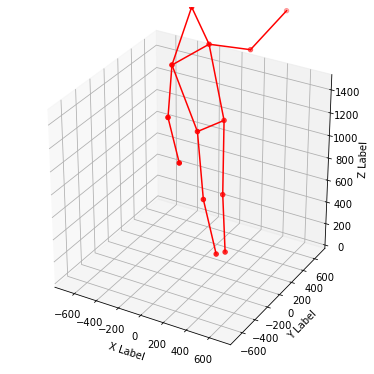

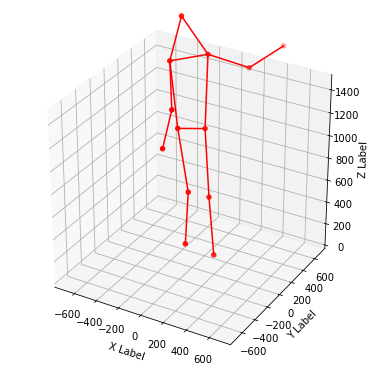

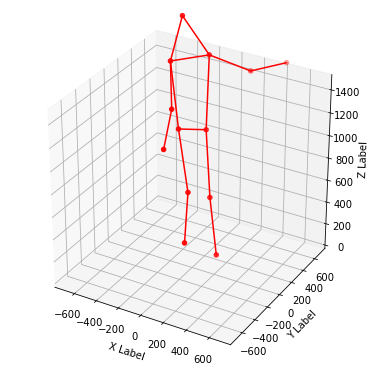

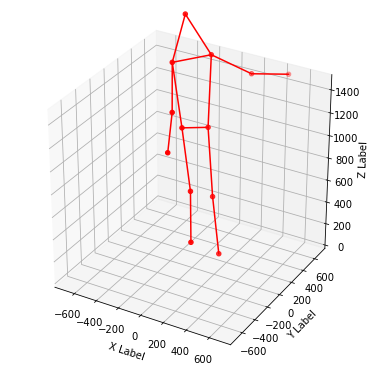

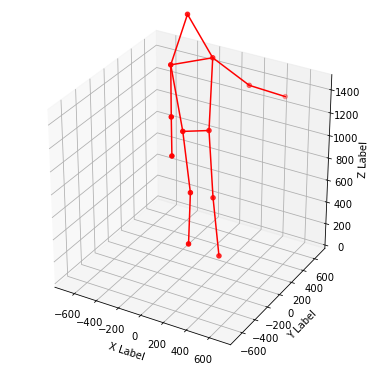

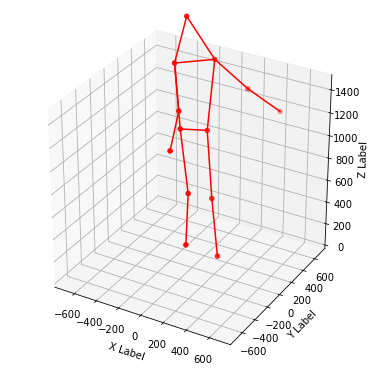

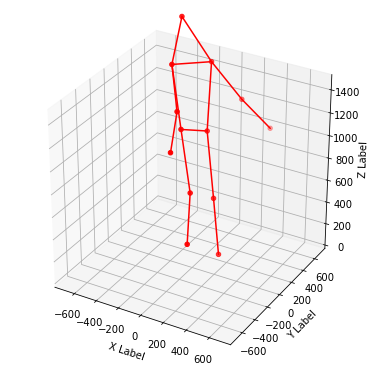

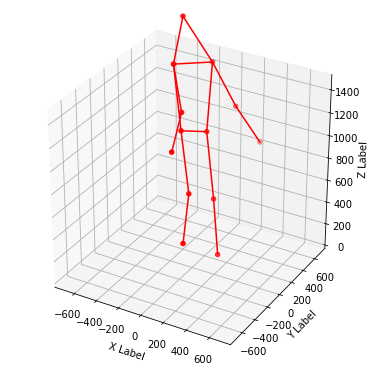

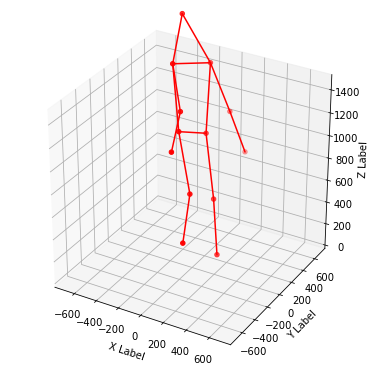

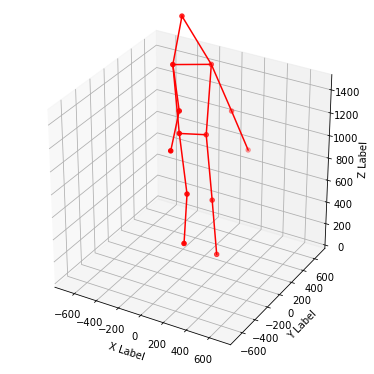

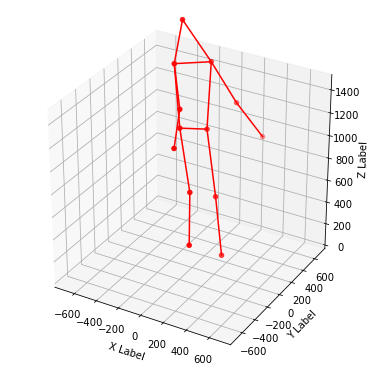

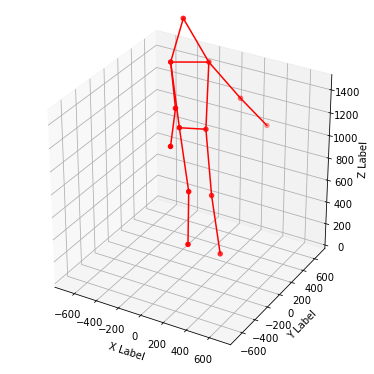

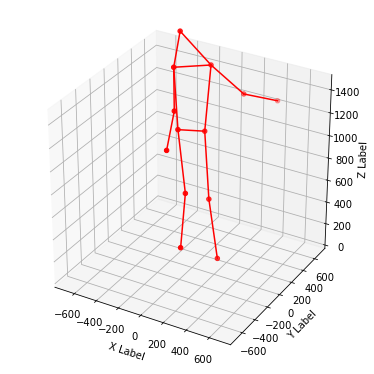

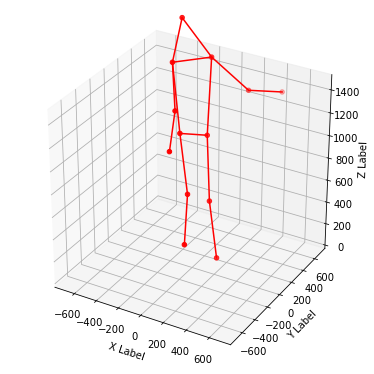

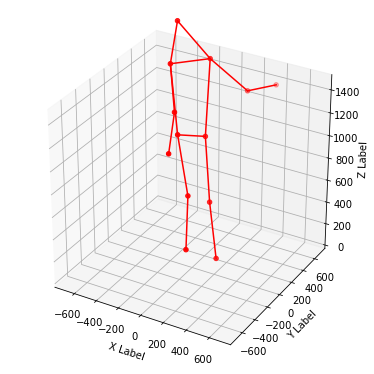

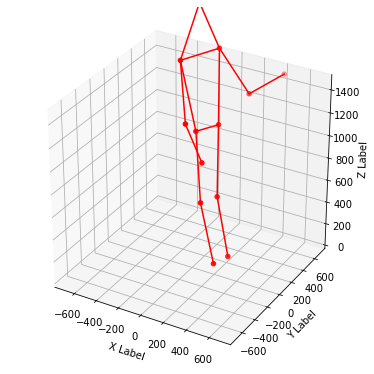

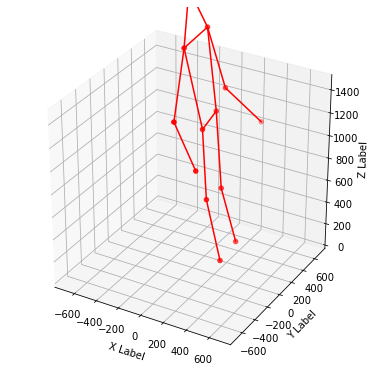

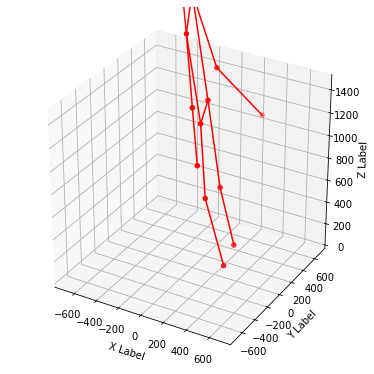

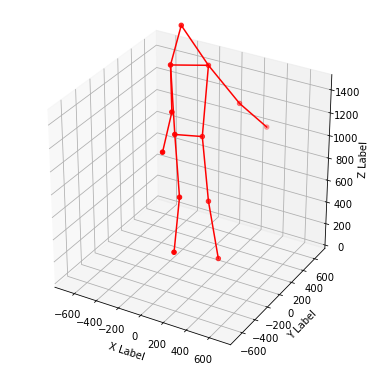

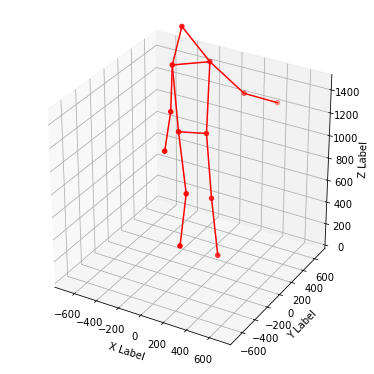

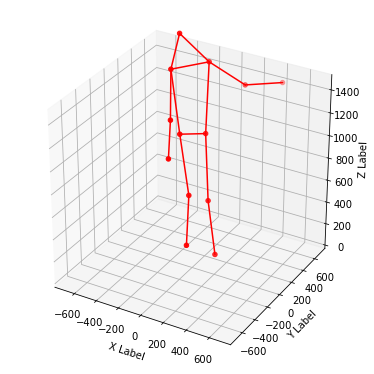

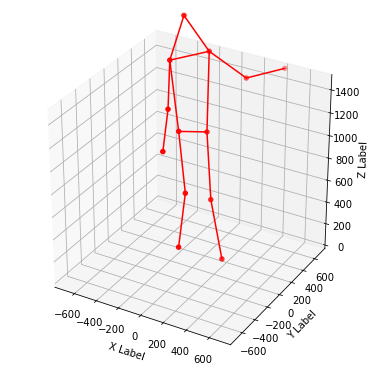

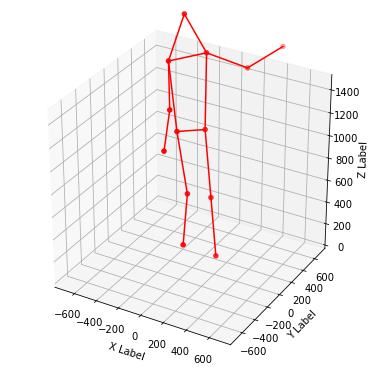

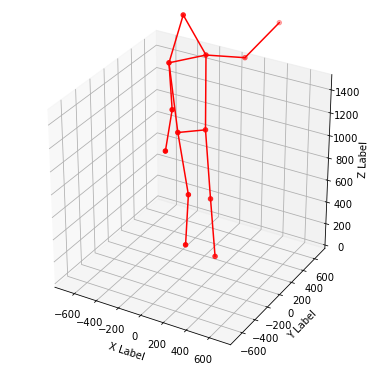

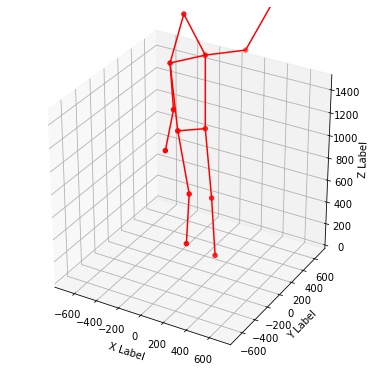

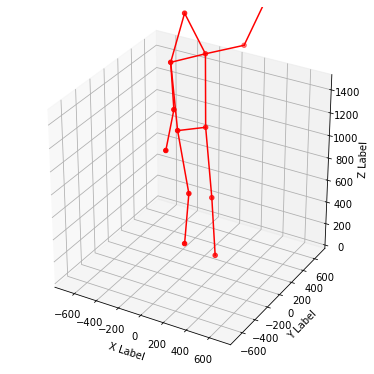

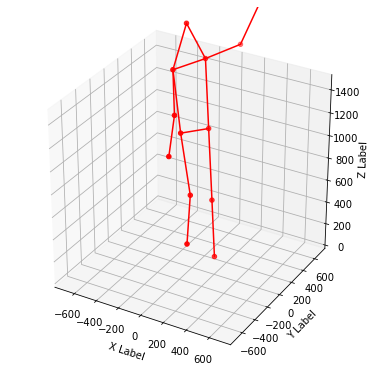

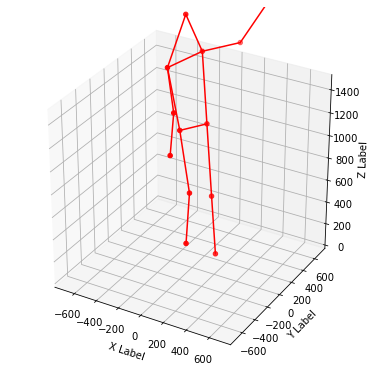

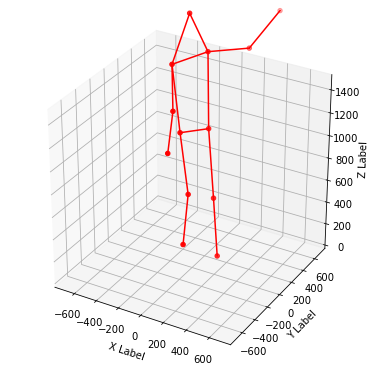

RuntimeError: Given groups=1, weight of size [64, 4, 7, 7], expected input[1, 3, 260, 346] to have 4 channels, but got 3 channels instead

In [356]:


for i in range(32, 64):
    x = torch.unsqueeze(flat[i:i+4, :, :], 0)
    with torch.no_grad():
        preds = model(x.cpu())
    normalized_skeletons = model.predict3d(preds)
    normalized_skeletons
    
    pred_skeleton = normalized_skeletons[0].narrow(-1, 0, 3)
    pred_skeleton = utils.denormalize_predict(pred_skeleton,
                                                  260, 346, camera).numpy().swapaxes(1, 0)

    utils.plot_skeleton_3d(M, pred_skeleton)
    plt.savefig(f'test{i}.png')
    plt.show()
    plt.close()

In [347]:
with torch.no_grad():
    for i in range(len(frames)):
        f = frames[i] / 255.
        f = f.swapaxes(0, 1)
        augmented = aug(image=f)
        x = augmented['image'].unsqueeze(0).unsqueeze(0)

        preds = model(x.cpu())
        normalized_skeletons = model.predict3d(preds)

        pred_skeleton = normalized_skeletons[0].narrow(-1, 0, 3)
        pred_skeleton = utils.denormalize_predict(pred_skeleton,
                                                  260, 346, K).numpy().swapaxes(1, 0)

        utils.plot_skeleton_3d(M, pred_skeleton)
        plt.show()
        plt.savefig(f'test{i}.png')
        plt.close()


RuntimeError: Given groups=1, weight of size [64, 4, 7, 7], expected input[1, 1, 260, 346] to have 4 channels, but got 1 channels instead

In [277]:
writer = cv2.VideoWriter("input.avi", cv2.VideoWriter_fourcc(*"MJPG"), 3,
                      (346, 260))
for im in frames:
        f = im.swapaxes(0, 1)
        f = np.expand_dims(f, -1)
        f = np.concatenate([f, f, f], axis=-1)
        writer.write(f.astype('uint8'))
writer.release()



In [10]:
writer = cv2.VideoWriter("pred.avi", cv2.VideoWriter_fourcc(*"MJPG"), 3,
                         (360, 360))
images = sorted(glob.glob("*.png"))
for frame in images:
    im = cv2.imread(frame)
    writer.write(im.astype('uint8'))
writer.release()



NameError: name 'cv2' is not defined

In [9]:
frame.shape

NameError: name 'frame' is not defined